In [1]:
import math
from numpy import linalg as LA
import numpy as np
from matplotlib import pyplot as plt 

import random
import os
from numba import njit, prange, cuda
import itertools
import sympy as sp

def fFeim(x, pole, resi, sigma=1):
    return 1 / 2 - sigma * sum(2.0 * resi[i] * x / (x**2 + pole[i]**2)
                               for i in range(len(pole)))


def tseig(D, E):
    mat = np.diag(E, -1) + np.diag(D, 0) + np.diag(E, 1)
    return -np.sort(-np.linalg.eigvalsh(mat))

def PSD(N, BoseFermi=2, pade=0):
    if N < 0 or BoseFermi < 1 or BoseFermi > 2 or pade < 0 or pade > 3:
        raise ValueError("N or BoseFermi or pade has wrong value!")

    if pade == 0:
        return MSD(N, BoseFermi)
    elif pade == 1 or pade == 2:
        pole, resi = [], []
        if N > 0:
            M = 2 * N + pade // 2
            temp = 3.0 if BoseFermi == 1 else 1.0
            diag = np.zeros(M, dtype=float)
            doff = np.array([
                1.0 / math.sqrt((temp + 2.0 * i) * (temp + 2.0 * (i + 1)))
                for i in range(M - 1)
            ])
            pole = 2.0 / tseig(diag, doff)[:N]
            pol2 = np.array([x * x for x in pole])
            M -= 1
            temp = 5.0 if BoseFermi == 1 else 3.0
            diag = np.zeros(M, dtype=float)
            doff = np.array([
                1.0 / math.sqrt((temp + 2.0 * i) * (temp + 2.0 * (i + 1)))
                for i in range(M - 1)
            ])
            M //= 2
            eig2 = np.power(2.0 / tseig(diag, doff)[:M], 2)
            print(eig2)

            scaling = 0.0
            if BoseFermi == 1:
                scaling = N*(2.0*N+3.0) if pade == 1 else 1.0 / \
                    (4.0*(N+1.0)*(2.0*N+3.0))
            elif BoseFermi == 2:
                scaling = N*(2.0*N+1.0) if pade == 1 else 1.0 / \
                    (4.0*(N+1.0)*(2.0*N+1.0))
            resi = np.zeros(N, dtype=float)
            for j in range(N):
                if pade == 2:
                    temp = 0.5 * scaling * (eig2[j] - pol2[j])
                elif pade == 1:
                    if j == N - 1:
                        temp = 0.5 * scaling
                    else:
                        temp = 0.5*scaling * \
                            (eig2[j]-pol2[j])/(pol2[N-1]-pol2[j])
                for k in range(M):
                    temp *= (eig2[k]-pol2[j]) / \
                        (pol2[k]-pol2[j]) if k != j else 1.0
                resi[j] = temp
        rn, tn = 0.0, 0.0
        if BoseFermi == 1 and pade == 2:
            rn = 1.0 / (4.0 * (N + 1.0) * (2.0 * N + 3.0))
        return pole, resi
    elif pade == 3:
        Np1 = N + 1
        temp = 3.0 if BoseFermi == 1 else 1.0
        d = np.empty(2 * Np1, dtype=float)
        d[0] = 0.25 / temp
        d[-1] = -4.0 * (N + 1.0) * (N + 1.0) * (temp + 2 * N) * (
            temp + 2 * N) * (temp + 4 * N + 2.0)
        for i in range(1, Np1):
            d[2*i-1] = -4.0*i*i*(temp+2.0*i-2.0) * \
                (temp+2.0*i-2.0)*(temp+4.0*i-2.0)
            d[2 * i] = -0.25 * (temp + 4.0 * i) / i / (i + 1) / (
                temp + 2.0 * i - 2.0) / (temp + 2.0 * i)
        sumd2 = np.empty(Np1, dtype=float)
        sumd2[0] = d[1]
        for i in range(1, Np1):
            sumd2[i] = sumd2[i - 1] + d[2 * i + 1]
        tn = 0.25 / sumd2[-1]
        rn = sum(d[2 * i] * (4.0 * tn *
                             (sumd2[-1] - sumd2[i - 1]))**2 if i > 0 else d[2 *
                                                                            i]
                 for i in range(Np1))
        M = 2 * N + 1
        diag = np.zeros(M, dtype=float)
        doff = np.array(
            [1.0 / math.sqrt(d[i + 1] * d[i + 2]) for i in range(M - 1)])
        pole = 2.0 / tseig(diag, doff)[:N]
        resi = np.zeros(N, dtype=float)
        for j in range(N):
            scaling = pole[j] * pole[j]
            r0, t1 = 0.0, 0.25 / d[1]
            eta0, eta1, eta2 = 0.0, 0.5, 0.0
            for i in range(Np1):
                r1 = t1 if (i == j
                            or i == N) else t1 / (pole[i] * pole[i] - scaling)
                r2 = 2.0*math.sqrt(abs(r1)) if r1 > 0 else - \
                    2.0*math.sqrt(abs(r1))
                r1 = 2.0 * math.sqrt(abs(r1))
                eta2 = d[2 * i] * r1 * eta1 - 0.25 * r1 * r0 * scaling * eta0
                eta0 = eta1
                eta1 = eta2
                eta2 = d[2 * i +
                         1] * r2 * eta1 - 0.25 * r2 * r1 * scaling * eta0
                eta0 = eta1
                eta1 = eta2
                r0 = r2
                if i != N:
                    t1 = sumd2[i] / sumd2[i + 1]
            resi[j] = eta2
        return pole, resi

@njit()
def fit_J(w, res, expn, etal, sigma):
    for i in range(len(etal)):
        res += etal[i] / (expn[i] + sigma * 1.j * w )


@njit()
def fit_t(t, res, expn, etal):
    for i in range(len(etal)):
        res += etal[i] * np.exp(-expn[i] * t)
    return res

<ipython-input-2-285a7c16af41>:33: RuntimeWarning: overflow encountered in exp
  tmp = jw / (1 + np.exp(sigma * beta * (w - mu_x)))
<ipython-input-2-285a7c16af41>:34: RuntimeWarning: overflow encountered in exp
  tmp_1 = tmp / max(jw / (1 + np.exp(sigma * beta * (w - mu_x))))
<ipython-input-2-285a7c16af41>:36: RuntimeWarning: overflow encountered in exp
  plt.plot(w, 1/(1 + np.exp(sigma * beta * (w - mu_x))), label='fermi')


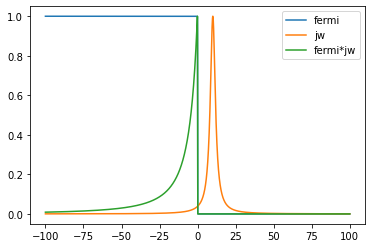

In [2]:
nmod = 4
lams1 = 0.2
lams2 = 0
gams1 = 2.0
gams2 = 0
omgs1 = 10.0
omgs2 = 0
temp = 0.02
beta = int(1 / temp)
mu_x = 0

#random_expn = 10 *  (np.random.rand(5))
#random_etal = np.abs(np.random.rand(5))

def gen_jw(w):
         return lams1 * gams1**2 / ((w  - omgs1)**2 + gams1**2)
    #     jw = np.zeros_like(w)
    #index = (w <= gams1) & (w >= -gams1)
    
    #     jw = lams1 * np.exp(-np.abs(w) / gams1)
    #jw = 0 * w
    #for i in range(len(random_expn)):
    #    jw[index] += random_etal[i] / ((w[index] - random_expn[i])**2 + 0.01)
    #return jw

len_ = 5000 + 1
spe_wid = 100
w = np.linspace(-spe_wid, spe_wid, len_)


sigma = 1
jw = gen_jw(w)
tmp = jw / (1 + np.exp(sigma * beta * (w - mu_x)))
tmp_1 = tmp / max(jw / (1 + np.exp(sigma * beta * (w - mu_x))))

plt.plot(w, 1/(1 + np.exp(sigma * beta * (w - mu_x))), label='fermi')
plt.plot(w, jw/max(jw), label='jw')
plt.plot(w, tmp_1, label='fermi*jw')
plt.legend(loc=1)
# plt.xlim(-15, 15)

In [3]:
# 4 - np.random.rand(10)*2

In [4]:
# n = 2500
# scale = 500
# scale_fft = 100
# n_fft = 10000000

# n_rate = (scale_fft * scale/ (4 * n))
# print(n_rate)
# n_rate = int(n_rate)
# w = np.linspace(0, scale_fft * np.pi, n_fft + 3)[:-1]
# dw = w[1] - w[0]

# jw = gen_jw(w)
# cw1 = jw / (1 + np.exp(- sigma * beta * (w - mu_x)))
# cw2 = jw / (1 + np.exp(sigma * beta * (w - mu_x)))
# # del jw

# cw1[0] = cw1[0] / 2
# cw2[0] = cw2[0] / 2
# if sigma == -1:
#     fft_ct = (np.fft.ifft(cw1) * len(cw1) * dw + np.fft.fft(cw2) * dw) / np.pi
# if sigma == 1:
#     fft_ct = (np.fft.fft(cw1) * dw + np.fft.ifft(cw2) * len(cw2) * dw) / np.pi
# fft_t = 2 * np.pi * np.fft.fftfreq(len(cw1), dw)
# del cw1, cw2

# print(max(fft_t))
# fft_ct = fft_ct[(scale>=fft_t) & (fft_t >= 0)][::n_rate]
# fft_t = fft_t[(scale>=fft_t) & (fft_t >= 0)][::n_rate]
# t = fft_t
# res_t = np.zeros(len(t), dtype=complex)

# plt.plot(w, jw / (1 + np.exp(sigma * beta * (w - mu_x))))

# # fft_ct[0] = fft_ct[0] / 2
# plt.plot(2 * np.pi * np.fft.fftfreq(len(fft_ct), fft_t[1]-fft_t[0]), len(fft_ct) * (fft_t[1]-fft_t[0]) * np.fft.ifft(fft_ct))
# # fft_ct[0] = fft_ct[0] * 2

# plt.xlim(-50, 50)
# plt.show()

In [5]:
def decompose_spe(spe,
                  sp_para_dict,
                  para_dict,
                  condition_dict,
                  npsd,
                  sigma,
                  pade=1):
    numer, denom = sp.cancel(sp.factor(
        spe.subs(condition_dict))).as_numer_denom()
    numer_get_para = (sp.factor(numer)).subs(sp_para_dict)
    denom_get_para = (sp.factor(denom)).subs(sp_para_dict)
    poles = sp.nroots(denom_get_para)
    float(sp.re(poles[0]))

    print(poles)

    expn = []
    poles_allplane = np.array([])
    for i in poles:
        i = complex(i)
        if i.imag * sigma > 0:
            expn.append(-sigma * i * 1.J)
        poles_allplane = np.append(poles_allplane, i)

    etal = []
    etar = []
    etaa = []

    expn = np.array(expn)

    expn_imag_sort = np.argsort(np.abs(np.imag(expn)))[::-1]
    expn_imag = np.sort(np.abs(np.imag(expn)))[::-1]

    expn_val_cc = []
    # expn_arg_cc = expn_imag_sort[expn_imag != 0]
    expn_val_n_cc = expn
    # expn_arg_n_cc = expn_imag_sort[expn_imag == 0]

    expn = list(expn[expn_imag_sort])
    pole, resi = PSD(npsd, 2, 1)
    beta = para_dict['beta']
    temp = 1 / beta

    for ii in range(len(expn_val_n_cc)):
        etal.append(
            complex(
                sp.N((sigma * 2.j * numer_get_para / np.multiply.reduce(
                    w_sp - poles_allplane[np.abs(poles_allplane - sigma * 1.J *
                                                 expn_val_n_cc[ii]) > 1e-14])
                      ).subs({w_sp: sigma * 1.j * expn_val_n_cc[ii]}) *
                     fFeim(sigma * 1.J * expn_val_n_cc[ii] / temp, pole, resi,
                           sigma))))
        etar.append(np.conj(etal[-1]))
        etaa.append(np.sqrt(np.abs(etal[-1]) * np.abs(etar[-1])))

    f = numer_get_para / np.multiply.reduce(w_sp - poles_allplane)
    f = sp.lambdify(w_sp, f)

    for inma in range(len(pole)):
        print(pole[inma])
        zomg = sigma * 1.J * pole[inma] * temp
        jsum = np.sum(f(zomg))
        expn.append(pole[inma] * temp)
        etal.append(-2.J * resi[inma] * temp * jsum)
        etar.append(np.conj(etal[-1]))
        etaa.append(np.abs(etal[-1]))

    etal = np.array(etal)
    etar = np.array(etar)
    etaa = np.array(etaa)
    expn = np.array(expn)

    return etal, etar, etaa, expn



etal_pade_d = {}
expn_pade_d = {}

for npsd in [20]: #4, 9, 14, 512
    nmod = 4
    lams1 = lams1   
    lams2 = 1
    gams1 = gams1
    gams2 = 1
    omgs1 = omgs1
    omgs2 = 0
    temp = temp
    npfs = 6
    beta = int(1 / temp)  # in 298K
    # eta = 1.0
    mu_x = mu_x

    w_sp, lams1_sp, gams1_sp, omgs1_sp, gams2_sp, lams2_sp, omgs2_sp, beta_sp = sp.symbols(
        r"\omega , \lambda_1, \gamma_1, \Omega_1, \lambda_2, \gamma_2, \Omega_2, \beta",
        real=True)

    phixx_sp = lams1_sp * gams1_sp**2 / ((w_sp - omgs1_sp)**2 + gams1_sp**2)
    phixy_sp = 0
    phiyy_sp = lams2_sp * gams2_sp**2 / ((w_sp - omgs2_sp)**2 + gams2_sp**2)


    sp_para_dict = {
        lams1_sp: lams1,
        lams2_sp: lams2,
        gams1_sp: gams1,
        gams2_sp: gams2,
        omgs1_sp: omgs1,
        omgs2_sp: omgs2
    }

    condition_dict = {}
    para_dict1 = {'beta': beta}
    para_dict2 = {'beta': beta}

    etal_pade1, etar_pade1, etaa_pade1, expn_pade1 = decompose_spe(
        phixx_sp, sp_para_dict, para_dict1, condition_dict, npsd, -1)
    etal_pade2, etar_pade2, etaa_pade2, expn_pade2 = decompose_spe(
        phiyy_sp, sp_para_dict, para_dict2, condition_dict, npsd, 1)
    npsd = npsd + 1

    n_spe = 1

    len_ = 2000 + 1
    spe_wid = 100
    w = np.linspace(-spe_wid, spe_wid, len_)
    res_w = np.zeros(len(w), dtype=complex)

    phixx = lams1 * gams1**2 / (((w - mu_x) - omgs1)**2 + gams1**2)
    phixy = 0 * w
    phiyy = lams2 * gams2**2 / (((w - mu_x) - omgs2)**2 + gams2**2)

    fit_J(w, res_w, expn_pade1, etal_pade1, 1)
    
    
    etal_pade_d[npsd] = etal_pade1
    expn_pade_d[npsd] = expn_pade1

[-10.0 - 2.0*I, -10.0 + 2.0*I]
[3.94784176e+01 1.57913670e+02 3.55305758e+02 6.31654682e+02
 9.86960440e+02 1.42122303e+03 1.93444246e+03 2.52661873e+03
 3.19775187e+03 3.94785558e+03 4.77818444e+03 5.71808109e+03
 6.94761306e+03 8.86267552e+03 1.21210495e+04 1.82005592e+04
 3.14112317e+04 6.92360915e+04 2.73607309e+05]
3.141592653589795
9.42477796076937
15.707963267948966
21.991148575128584
28.27433388230812
34.5575191894877
40.84070449666735
47.123889803851
53.40707512267524
59.690267730095854
65.97463939836028
72.30981839851239
79.22163897259144
88.24769969102927
101.30419434924487
121.03608235209411
152.952636490974
211.47247294906302
349.59500590291066
1044.578518259254
[-1.0*I, 1.0*I]
[3.94784176e+01 1.57913670e+02 3.55305758e+02 6.31654682e+02
 9.86960440e+02 1.42122303e+03 1.93444246e+03 2.52661873e+03
 3.19775187e+03 3.94785558e+03 4.77818444e+03 5.71808109e+03
 6.94761306e+03 8.86267552e+03 1.21210495e+04 1.82005592e+04
 3.14112317e+04 6.92360915e+04 2.73607309e+05]
3.1415926

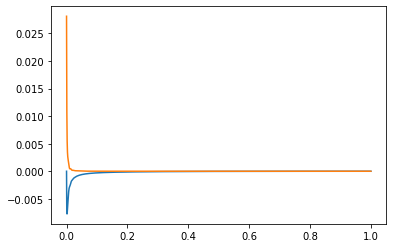

diss_rate_pade
 [ 2.        -10.j  0.06283185 +0.j  0.18849556 +0.j  0.31415927 +0.j
  0.43982297 +0.j  0.56548668 +0.j  0.69115038 +0.j  0.81681409 +0.j
  0.9424778  +0.j  1.0681415  +0.j  1.19380535 +0.j  1.31949279 +0.j
  1.44619637 +0.j  1.58443278 +0.j  1.76495399 +0.j  2.02608389 +0.j
  2.42072165 +0.j  3.05905273 +0.j  4.22944946 +0.j  6.99190012 +0.j
 20.89157037 +0.j]
eta_pade
 [2.30630942e-04+0.00069959j 3.71760059e-06-0.00030766j
 1.11465517e-05-0.00030739j 1.85567774e-05-0.00030686j
 2.59358764e-05-0.00030607j 3.32715701e-05-0.00030501j
 4.05517509e-05-0.0003037j  4.77645285e-05-0.00030213j
 5.48982758e-05-0.00030031j 6.19416726e-05-0.00029824j
 6.88842127e-05-0.00029594j 7.57791457e-05-0.00029364j
 8.46765871e-05-0.00029834j 1.09265152e-04-0.00034994j
 1.68527729e-04-0.00048165j 2.80808433e-04-0.00069226j
 5.04323173e-04-0.00102231j 1.01661504e-03-0.00157262j
 2.43681074e-03-0.00248068j 7.28030509e-03-0.00286933j
 1.55773396e-02+0.01239449j]
res_t[:20].real
 [2.52274792e-0

/home/ZDC/program/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


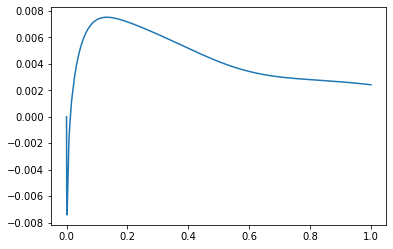

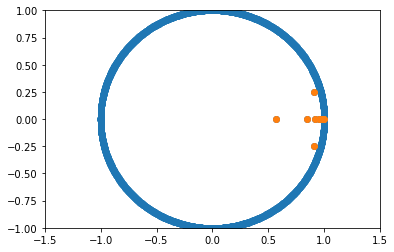

[0.57220148+0.00000000e+00j 0.84477675-1.46752927e-18j
 0.92084325-6.24829587e-16j 0.91457055+2.49885342e-01j
 0.91457055-2.49885342e-01j 0.95986419-9.78682528e-16j
 0.97991013+2.31100740e-15j 0.98986518+4.39491779e-16j
 0.99486293+1.53265952e-15j 0.9983253 -4.98883887e-17j]

vs_real[:20]
 [7.03514732e-02 1.33916072e-02 3.83643170e-03 2.10567346e-03
 1.40083450e-03 7.66968305e-04 2.23318556e-04 4.77667344e-05
 8.24231326e-06 1.16981031e-06 1.37078589e-07 1.32328619e-08
 1.04438554e-09 6.65736635e-11 3.37118434e-12 1.32718912e-13
 3.94983479e-15 8.54685154e-17 1.66714702e-17 5.09388226e-18]
error of decompose 4.930275268437629e-15
len of gamma 10
para
[-0.01165283+0.j -0.01166853+0.j -0.01168423+0.j ...  0.11799893+0.j
  0.12227173+0.j -0.1026286 +0.j]


/home/ZDC/program/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


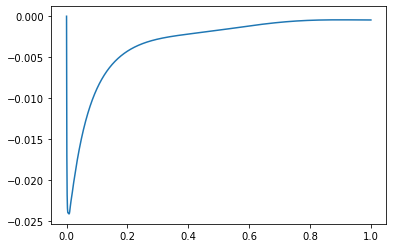

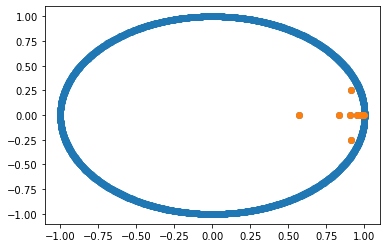

[0.57302495+0.00000000e+00j 0.83268036+1.55706046e-16j
 0.908073  -1.37183034e-15j 0.91454001+2.49829186e-01j
 0.91454001-2.49829186e-01j 0.95093392+1.61489328e-15j
 0.9752912 -9.47689338e-16j 0.98812536+1.41887831e-15j
 0.99455486-3.71052360e-16j 0.99831724-1.77635684e-15j]


In [6]:
n = 1500
scale = 80
n_sample = n + 1
n_gamma_l = [10]

t = np.linspace(0, 1, 2 * n + 1)
res_t = np.zeros(len(t), dtype=complex)
fit_t(scale * t, res_t, expn_pade1, etal_pade1)
plt.plot(t, np.imag(res_t))
plt.plot(t, np.real(res_t))
plt.show()

print("diss_rate_pade\n", expn_pade1)
print("eta_pade\n", etal_pade1)
print("res_t[:20].real\n", res_t[2980:].real)
print("res_t[:20].imag\n", res_t[2980:].imag)

print()

h = np.imag(res_t)
H = np.zeros((n_sample, n_sample))
for i in range(n_sample):
    H[i, :] = h[i:n_sample + i]
sing_vs, Q = LA.eigh(H)
# print(H[1,1500])
# print("vs_imag[:20]\n",sing_vs[:20])

# del H
phase_mat = np.diag(
    [np.exp(-1j * np.angle(sing_v) / 2.0) for sing_v in sing_vs])
vs = np.array([np.abs(sing_v) for sing_v in sing_vs])
Qp = np.dot(Q, phase_mat)
sort_array = np.argsort(vs)[::-1]
vs = vs[sort_array]
Qp = (Qp[:, sort_array])
#print(vs[:100])
vs = vs[:20]
Qp = Qp[:, :20]

print("vs_imag[:20]\n",vs[:20])

for n_gamma in n_gamma_l:
    print(
        "error of decompose",
        np.sum(np.abs(H -
                  np.dot(np.dot(Qp, np.diag(vs)), (np.transpose(Qp))))))
    print("len of gamma", n_gamma)
    gamma = np.roots(Qp[:, n_gamma][::-1])
    gamma_new = gamma[np.argsort(np.abs(gamma))[:n_gamma]]
    t_imag = 2 * n * np.log(gamma_new)
    gamma_m = np.zeros((n_sample * 2 - 1, n_gamma), dtype=complex)
    for i in range(n_gamma):
        for j in range(n_sample * 2 - 1):
            gamma_m[j, i] = gamma_new[i]**j
    omega_imag = np.dot(LA.inv(np.dot(np.transpose(gamma_m), gamma_m)),
                        np.dot(np.transpose(gamma_m), np.transpose(h)))

    res_t_imag = np.zeros(len(t), dtype=complex)
    fit_t(t, res_t_imag, -t_imag / scale, omega_imag)
    plt.plot(t, np.imag(res_t) - res_t_imag)
    #plt.savefig("imag_{}.pdf".format(n_gamma))
    plt.show()
    plt.scatter(np.real(gamma),np.imag(gamma))
    plt.scatter(np.real(gamma_new),np.imag(gamma_new))
    plt.xlim(-1.5,1.5)
    plt.ylim(-1,1)
    plt.show()
    print(gamma_new)

print()

h = np.real(res_t)
H = np.zeros((n_sample, n_sample))
for i in range(n_sample):
    H[i, :] = h[i:n_sample + i]
sing_vs, Q = LA.eigh(H)


# print("vs_real[:20]\n",sing_vs[:20])

# del H
phase_mat = np.diag(
    [np.exp(-1j * np.angle(sing_v) / 2.0) for sing_v in sing_vs])
vs = np.array([np.abs(sing_v) for sing_v in sing_vs])
Qp = np.dot(Q, phase_mat)
sort_array = np.argsort(vs)[::-1]
vs = vs[sort_array]
Qp = (Qp[:, sort_array])
#print(vs[:100])
vs = vs[:20]
Qp = Qp[:, :20]


print("vs_real[:20]\n",vs[:20])

for n_gamma in n_gamma_l:
    print(
        "error of decompose",
        np.sum(np.abs(H -
                  np.dot(np.dot(Qp, np.diag(vs)), (np.transpose(Qp))))))
    print("len of gamma", n_gamma)
    gamma = np.roots(Qp[:, n_gamma][::-1])
    
    print("para")
    print(Qp[:, n_gamma][::-1])
    
    gamma_new = gamma[np.argsort(np.abs(gamma))[:n_gamma]]
    t_real = 2 * n * np.log(gamma_new)
    gamma_m = np.zeros((n_sample * 2 - 1, n_gamma), dtype=complex)
    for i in range(n_gamma):
        for j in range(n_sample * 2 - 1):
            gamma_m[j, i] = gamma_new[i]**j
    omega_real = np.dot(LA.inv(np.dot(np.transpose(gamma_m), gamma_m)),
                        np.dot(np.transpose(gamma_m), np.transpose(h)))
    res_t_real = np.zeros(len(t), dtype=complex)
    fit_t(t, res_t_real, -t_real / scale, omega_real)
    plt.plot(t, np.real(res_t) - res_t_real)
    #plt.savefig("real_{}.pdf".format(n_gamma))
    plt.show()
    plt.scatter(np.real(gamma),np.imag(gamma))
    plt.scatter(np.real(gamma_new),np.imag(gamma_new))
    #plt.xlim(-1.5,1.5)
    #plt.ylim(-1,1)
    plt.show()
    print(gamma_new)


diss_rate_prony1
 [20.93490406-0.00000000e+00j  6.32560812+6.51442494e-17j
  3.09245462+2.54452749e-14j  1.99881627-1.00018911e+01j
  1.99881627+1.00018911e+01j  1.53613021+3.82351953e-14j
  0.76104054-8.84395156e-14j  0.38199473-1.66496832e-14j
  0.19313671-5.77715085e-14j  0.06285404+1.87395289e-15j
 20.88097555-0.00000000e+00j  6.86645379-7.01226669e-15j
  3.6161441 +5.66514341e-14j  2.00056681-1.00000667e+01j
  2.00056681+1.00000667e+01j  1.88665134-6.36831819e-14j
  0.93821966+3.64387071e-14j  0.44796384-5.38473545e-14j
  0.20475074+1.39906445e-14j  0.06315658+6.67256646e-14j]
eta_prony
 [-3.20576898e-15+1.23270529e-02j  1.87211358e-14-3.90657762e-03j
 -7.70217223e-15-4.07258999e-03j  1.15744713e-04+3.49021475e-04j
 -1.15744713e-04+3.49021475e-04j  4.16333634e-17-2.47640157e-03j
  9.71445147e-17-1.28348436e-03j  7.97972799e-17-6.28825135e-04j
 -1.89518540e-16-3.48991454e-04j -2.43945489e-18-3.08065135e-04j
  1.56002615e-02-5.34849942e-14j  7.75852898e-03+2.35228503e-14j
  3.092685

<ipython-input-7-7e1417ca515f>:24: RuntimeWarning: overflow encountered in exp
  phixx = gen_jw(w) / (1 + np.exp(sigma * beta * (w - mu_x)))


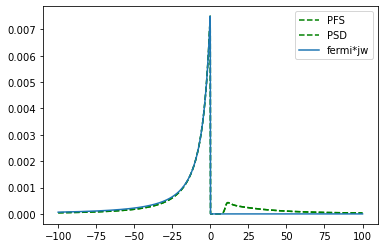

In [7]:
etal1 = np.append(1.j * omega_imag, omega_real)
etar1 = np.append(np.conjugate(1.j * omega_imag), np.conjugate(omega_real))
etaa1 = np.append(np.abs(omega_imag), np.abs(omega_real))
expn1 = np.append(-t_imag / scale, -t_real / scale)

print("diss_rate_prony1\n", expn1)
print("eta_prony\n", etal1)

#filter_ = 1e-4
#print(len(expn1[np.abs(etal1) <= filter_]))
#expn1 = expn1[np.abs(etal1) > filter_]
#etal1 = etal1[np.abs(etal1) > filter_]

# if sigma == 1:
np.savetxt("expn1", expn1)
np.savetxt("etal1", etal1)
# if sigma == -1:
np.savetxt("expn2", expn1)
np.savetxt("etal2", etal1)

len_ = 5000 + 1
spe_wid = 100
w = np.linspace(-spe_wid, spe_wid, len_)
phixx = gen_jw(w) / (1 + np.exp(sigma * beta * (w - mu_x)))
res_J1 = np.zeros(len(w), dtype=complex)
fit_J(w, res_J1, expn1, etal1, sigma)

res_J2 = np.zeros(len(w), dtype=complex)
fit_J(w, res_J2, expn_pade1, etal_pade1, sigma)


#print("res_J1\n", res_J1)
print("expn1\n", expn1)
print("etal1\n", etal1)

#plt.plot(w, (phixx.real)/max((phixx.real)), "b", label="exact")
plt.plot(w, (res_J1.real), "g--", label="PFS")
plt.plot(w, (res_J2.real), "g--", label="PSD")
plt.plot(w, tmp, label='fermi*jw')
plt.legend(loc=1)
#plt.xlim(30, 70)

x = 2500
print('w', w[x-1], "prony", (res_J1[x-1].real))
print('w', w[x-1], "pade ", (res_J2[x-1].real))
print('w', w[x-1], "exact", (tmp[x-1].real))

print('w', w[x], "prony", (res_J1[x].real))
print('w', w[x], "pade ", (res_J2[x].real))
print('w', w[x], "exact", (tmp[x].real))

print('w', w[x+1], "prony", (res_J1[x+1].real))
print('w', w[x+1], "pade ", (res_J2[x+1].real))
print('w', w[x+1], "exact", (tmp[x+1].real))